In [223]:
import pandas as pd
import numpy as np
import dateutil.parser
import matplotlib.pyplot as plt
import seaborn as sns
import calendar
import json
import datetime
from sklearn.neighbors import KNeighborsClassifier
from sklearn.learning_curve import learning_curve
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.cross_validation import train_test_split, cross_val_score, cross_val_predict
from urllib2 import Request, urlopen
from pandas.io.json import json_normalize
from patsy import dmatrices
%matplotlib inline

In [2]:
divvy_df = pd.read_csv('bigfile.csv', sep = ',')

In [4]:
divvy_df.shape
#holy cow batman, 2,454,634 total divvy trips in 2014.

(2454634, 12)

In [98]:
divvy_df['to_station_id'].nunique()
#there are 300 unique station IDs but the range is from 5 to 351

300

In [9]:
#converting to datetime objects and then wiping out the mins and secs so we can bin by hour.

def hourbinner(fulltime):
    return dateutil.parser.parse(fulltime).replace(minute=0, second=0)

In [10]:
#making a deep copy of the DF.

divvy_hr_df = divvy_df.copy(deep = True)

In [13]:
#converting to datetime objects and then wiping out the mins and secs so we can bin by hour.

divvy_hr_df.starttime = divvy_hr_df.starttime.apply(lambda x: hourbinner(x))
divvy_hr_df.stoptime = divvy_hr_df.stoptime.apply(lambda x: hourbinner(x))

#this took like 5 mins, at least 

In [15]:
fromstation_starttime = divvy_hr_df.groupby(['from_station_name', 'starttime']).size()

#we have a multi-index, so lets start by moving 'from_station_name' out, using unstack.
ts = fromstation_starttime.unstack(level=0)

#now with a single-lvl DatetimeIndex, reindex by filling all empty values with 0
index = pd.date_range('2014-01-01', '2014-12-31', freq='H')
ts = ts.reindex(index, fill_value = 0)

#fill NaNs with 0s so they don't go away when you restack
ts = ts.fillna(0)

#restack
ts = ts.stack()

"""what's happening here"""
ts = ts.swaplevel(0,1)
ts = ts.sortlevel()
print 'Done here.'

Done here.


In [16]:
#same as above
tostation_stoptime = divvy_hr_df.groupby(['to_station_name', 'stoptime']).size()
vs = tostation_stoptime.unstack(level=0)
vs = vs.reindex(index, fill_value = 0)
vs = vs.fillna(0)
vs = vs.stack()
vs = vs.swaplevel(0,1)
vs = vs.sortlevel()
print 'Done here.'

Done here.


In [17]:
combined = pd.concat([ts, vs], axis=1)
combined.columns = ['outflow', 'inflow']
print 'Done here.'

Done here.


In [20]:
combined['flowdiff'] = combined['inflow'] - combined['outflow']
combined.index.names = ['station_name', 'hourly_time']
print 'Done here.'

Done here.


([<matplotlib.axis.XTick at 0x118dddb50>,
 <a list of 16 Text xticklabel objects>)

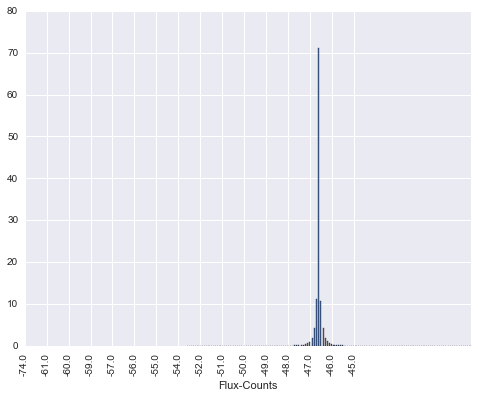

In [78]:
"""can't set the xticks properly for some reason, figure this out"""

flowdiff_distrib = combined['flowdiff'].value_counts()
percents = (flowdiff_distrib/2454634*100).sort_index()

fig = plt.figure(figsize = (8,6))
ax = fig.add_subplot(111)

percents.plot(use_index=True, kind = 'bar')
ax.set_xlabel("Flux-Counts")
# plt.xticks(np.arange(min(percents.index), max(percents.index)+1, 10.0))

In [80]:
combined.head()

outflow  inflow  flowdiff
station_name   hourly_time                                   
900 W Harrison 2014-01-01 00:00:00        0       0         0
               2014-01-01 01:00:00        0       0         0
               2014-01-01 02:00:00        0       0         0
               2014-01-01 03:00:00        0       0         0
               2014-01-01 04:00:00        0       0         0

In [81]:
#flattened the multi-index DF from above.

combined.reset_index(inplace=True)

In [126]:
combined.head()

,station_name,hourly_time,outflow,inflow,flowdiff
0,900 W Harrison,2014-01-01 00:00:00,0,0,0
1,900 W Harrison,2014-01-01 01:00:00,0,0,0
2,900 W Harrison,2014-01-01 02:00:00,0,0,0
3,900 W Harrison,2014-01-01 03:00:00,0,0,0
4,900 W Harrison,2014-01-01 04:00:00,0,0,0


In [127]:
#extracting the IDs to go with the station_name so we can match w the JSON info later.

#make a deep copy of just the station IDs and station names.
just_ID_name = divvy_df.copy(deep=True)[['from_station_id', 'from_station_name']]

#just because.
just_ID_name = just_ID_name.rename(columns = {'from_station_name':'station_name'})

#if you don't drop duplicates, it becomes a mess to join on.
just_ID_name = just_ID_name.drop_duplicates()

In [128]:
#merging the dataframes, it will automatically recognize and merge on the same key in this instance.
result = combined.merge(just_ID_name)
result = result.rename(columns = {'from_station_id':'id'})
print 'Done here.'

Done here.


In [129]:
result.head()

,station_name,hourly_time,outflow,inflow,flowdiff,id
0,900 W Harrison,2014-01-01 00:00:00,0,0,0,109
1,900 W Harrison,2014-01-01 01:00:00,0,0,0,109
2,900 W Harrison,2014-01-01 02:00:00,0,0,0,109
3,900 W Harrison,2014-01-01 03:00:00,0,0,0,109
4,900 W Harrison,2014-01-01 04:00:00,0,0,0,109


In [131]:
#getting the divvy JSON file 
request= Request('http://www.divvybikes.com/stations/json')
response = urlopen(request)
api = response.read()
api_data = json.loads(api)
#json_normalize takes a dict or list of dicts and normalizes this semi-structured data into a flat table
api_df = json_normalize(api_data['stationBeanList'])
api_df = api_df[["id", "latitude", "longitude", "stationName", "totalDocks"]]

In [132]:
api_df.head()

,id,latitude,longitude,stationName,totalDocks
0,2,41.872293,-87.624091,Michigan Ave & Balbo Ave,35
1,3,41.867226,-87.615355,Shedd Aquarium,31
2,4,41.856268,-87.613348,Burnham Harbor,23
3,5,41.874053,-87.627716,State St & Harrison St,23
4,6,41.885042,-87.612795,Dusable Harbor,31


In [133]:
#the api columns are in unicode, so we need them in utf-8 string format for merge matching purposes
api_df.columns = map(lambda x: x.encode('utf-8'), api_df.columns)
#time to merge on id!
bigresult = pd.merge(result, api_df, on='id')

In [135]:
#dropping the extra stationName column
bigresult.drop(bigresult.columns[[-2]], axis = 1, inplace = True)

In [138]:
bigresult.head()

,station_name,hourly_time,outflow,inflow,flowdiff,id,latitude,longitude,totalDocks
0,900 W Harrison,2014-01-01 00:00:00,0,0,0,109,41.874675,-87.650019,19
1,900 W Harrison,2014-01-01 01:00:00,0,0,0,109,41.874675,-87.650019,19
2,900 W Harrison,2014-01-01 02:00:00,0,0,0,109,41.874675,-87.650019,19
3,900 W Harrison,2014-01-01 03:00:00,0,0,0,109,41.874675,-87.650019,19
4,900 W Harrison,2014-01-01 04:00:00,0,0,0,109,41.874675,-87.650019,19


In [144]:
#creating extra predictor variables.

bigresult['dayofwk'] = bigresult['hourly_time'].apply(lambda x: calendar.day_name[x.weekday()])
bigresult['hour'] = bigresult['hourly_time'].apply(lambda x: x.hour)

print 'Done here.'

Done here.


In [145]:
#Reading in the weather data to append to our bigresult dataframe.

weather_df = pd.read_csv("2014weatherinfo.csv", sep = ',')
print 'Done here.'

Done here.


In [147]:
weather_df.shape

(8808, 3)

In [152]:
weather_df = weather_df.rename(columns = {'Unnamed: 0':'hourly'})

In [166]:
#new hourbinner function that gets rid of the tzinfo parameter
def tz_hourbinner(fulltime):
    return dateutil.parser.parse(fulltime).replace(minute=0, second=0, tzinfo=None)

In [176]:
weather_df.hourly = weather_df.hourly.apply(lambda x: tz_hourbinner(x))

In [179]:
print type(weather_df.hourly[0])

<class 'pandas.tslib.Timestamp'>


In [185]:
bigresult.head()

,station_name,hourly_time,outflow,inflow,flowdiff,id,latitude,longitude,totalDocks,flux,dayofwk,hour
0,900 W Harrison,2014-01-01 00:00:00,0,0,0,109,41.874675,-87.650019,19,0,Wednesday,0
1,900 W Harrison,2014-01-01 01:00:00,0,0,0,109,41.874675,-87.650019,19,0,Wednesday,1
2,900 W Harrison,2014-01-01 02:00:00,0,0,0,109,41.874675,-87.650019,19,0,Wednesday,2
3,900 W Harrison,2014-01-01 03:00:00,0,0,0,109,41.874675,-87.650019,19,0,Wednesday,3
4,900 W Harrison,2014-01-01 04:00:00,0,0,0,109,41.874675,-87.650019,19,0,Wednesday,4


In [186]:
weather_df.head()

,hourly,summary,temperature
0,2013-12-31 00:00:00,Overcast,10.69
1,2013-12-31 01:00:00,Light Snow,10.07
2,2013-12-31 02:00:00,Clear,9.30
3,2013-12-31 03:00:00,Clear,7.93
4,2013-12-31 04:00:00,Clear,7.32


In [188]:
weather_df = weather_df.rename(columns = {'hourly':'hourly_time'})

In [207]:
#merging those two dataframes on the common hourly_time column to create ... the big kahuna.

bigkahuna = pd.merge(bigresult, weather_df, on="hourly_time")
print 'Done here.'

Done here.


In [216]:
#sorting by station_name and then hourly_time, and then resetting the index

bigkahuna = bigkahuna.sort(['station_name', 'hourly_time']).reset_index(drop=True)

In [217]:
bigkahuna.head()

,station_name,hourly_time,outflow,inflow,flowdiff,id,latitude,longitude,totalDocks,flux,dayofwk,hour,summary,temperature
0,900 W Harrison,2014-01-01 00:00:00,0,0,0,109,41.874675,-87.650019,19,0,Wednesday,0,Overcast,16.24
1,900 W Harrison,2014-01-01 01:00:00,0,0,0,109,41.874675,-87.650019,19,0,Wednesday,1,Clear,17.76
2,900 W Harrison,2014-01-01 02:00:00,0,0,0,109,41.874675,-87.650019,19,0,Wednesday,2,Clear,19.20
3,900 W Harrison,2014-01-01 03:00:00,0,0,0,109,41.874675,-87.650019,19,0,Wednesday,3,Overcast,19.72
4,900 W Harrison,2014-01-01 04:00:00,0,0,0,109,41.874675,-87.650019,19,0,Wednesday,4,Clear,20.05


In [218]:
bigkahuna.shape

(2717207, 14)

In [219]:
#adding a flux column that categorizes both excessive inflow and outflow based on a threshold percentage 
#calculated on flowdiff/totalDocks for each station. (Done for every hour, as our dataframe is)

bigkahuna['flux'] = 0
bigkahuna.loc[(bigkahuna['flowdiff'] > 0) & (bigkahuna.flowdiff.abs() > (bigkahuna.totalDocks * 0.2)), 'flux'] = 1
bigkahuna.loc[(bigkahuna['flowdiff'] < 0) & (bigkahuna.flowdiff.abs() > (bigkahuna.totalDocks * 0.2)), 'flux'] = 2
print 'Done here.'

Done here.


In [220]:
bigkahuna['flux'].value_counts()

0    2608138
1      55289
2      53780
dtype: int64

In [142]:
1.0 - ((55289+53780)/(55289+53780+2608138.0))

# 0.959859 is our baseline stupid prediction of all 0s.

0.9598598855368766

In [222]:
#turning into design matrices and making sure the hour is taken in as a categorical variable.
y, X = dmatrices('flux ~ station_name + dayofwk + C(hour) + summary + temperature', data=bigkahuna, return_type='dataframe')

print 'Done here.'

Done here.


In [224]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1)

In [225]:
X_train.head()

,Intercept,station_name[T.Aberdeen St & Jackson Blvd],station_name[T.Aberdeen St & Madison St],station_name[T.Ada St & Washington Blvd],station_name[T.Adler Planetarium],station_name[T.Ashland Ave & 13th St],station_name[T.Ashland Ave & 21st St],station_name[T.Ashland Ave & Augusta Blvd],station_name[T.Ashland Ave & Belle Plaine Ave],station_name[T.Ashland Ave & Blackhawk St],...,summary[T.Snow (22–37 in.) and Windy],summary[T.Snow (Under 1 in.)],summary[T.Snow (Under 1 in.) and Breezy],summary[T.Snow (Under 1 in.) and Windy],summary[T.Snow and Windy],summary[T.Windy],summary[T.Windy and Mostly Cloudy],summary[T.Windy and Overcast],summary[T.Windy and Partly Cloudy],temperature
430586,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,62.63
397959,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,73.76
1110210,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,23.79
2160007,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,22.23
1848597,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,68.88


In [ ]:
estimators = [LogisticRegression(), GaussianNB(), SVC(probability = True), DecisionTreeClassifier(),
              RandomForestClassifier(n_jobs = -1), KNeighborsClassifier(n_neighbors=10), 
              GradientBoostingClassifier(learning_rate=0.4,  n_estimators=100, subsample=1.0, random_state=1, verbose=1)]

names = ['Logistic Regression', 'Gaussian Naive Bayes', 'Support Vector Machine', 'Decision Tree', 'Random Forest',
         'KNeighbors(10)', 'Gradient Boosting']

for i, estimator in enumerate(estimators):
    model = estimator.fit(X_train, y_train)
    print names[i], "has a test accuracy of", model.score(X_test, y_test)